In [3]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
combined_df = pd.read_csv(DATA_PATH)

print("Loaded:", combined_df.shape)
combined_df.head()


Loaded: (1458152, 28)


,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,...,g_y,g_z,subject_id,activity,pleth_3_filt,pleth_1_filt,pleth_2_filt,a_x_filt,a_y_filt,a_z_filt
0,2021-01-01 11:47:09.445505,19722,0,79526,78424,4406,85630,99618,6438,6584384,...,-0.478228,-0.710201,s12,run,-26.957562,-44.388652,-126.127361,-0.121752,0.270153,-0.227040
1,2021-01-01 11:47:09.447505,19817,0,79527,78417,4407,85630,99618,6438,6584384,...,-0.478495,-0.710867,s12,run,-25.897973,-42.984804,-122.841911,-0.145858,0.279853,-0.266853
2,2021-01-01 11:47:09.449505,19976,0,79518,78398,4405,85626,99619,6442,6584384,...,-0.476764,-0.711932,s12,run,-24.821582,-41.540573,-119.467507,-0.170565,0.297933,-0.298288
3,2021-01-01 11:47:09.451505,20136,0,79527,78410,4418,85627,99627,6444,6584384,...,-0.474367,-0.713663,s12,run,-23.728808,-40.055777,-116.004060,-0.192280,0.312419,-0.325533
4,2021-01-01 11:47:09.453505,20218,0,79527,78410,4418,85623,99610,6441,6584384,...,-0.471038,-0.715261,s12,run,-22.620070,-38.530252,-112.451508,-0.221778,0.315530,-0.362357


In [4]:
FS = 500              # Sampling frequency (Hz)
WINDOW_SEC = 5        # 5-second windows
WINDOW_SIZE = FS * WINDOW_SEC
STEP_SIZE = WINDOW_SIZE // 2   # 50% overlap

WINDOW_SIZE, STEP_SIZE


(2500, 1250)

In [5]:
def highpass_filter(signal, cutoff=0.3, fs=500, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return filtfilt(b, a, signal)


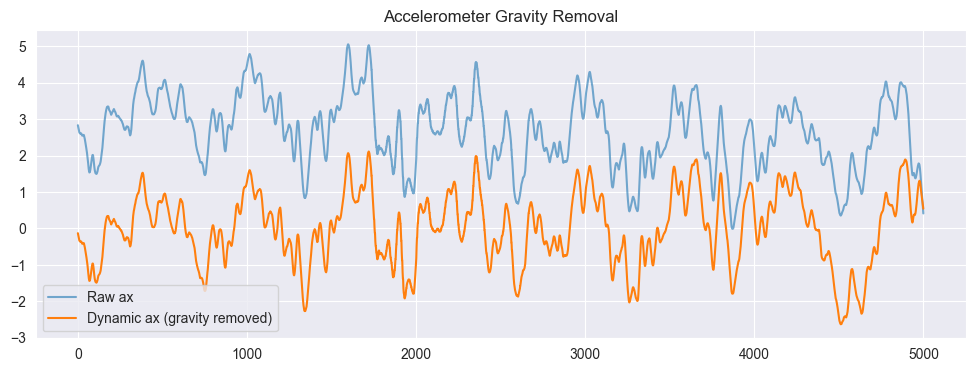

In [6]:
sample = combined_df[
    (combined_df["subject_id"] == "s12") &
    (combined_df["activity"] == "run")
].iloc[:5000]

ax_raw = sample["a_x"].values
ax_dyn = highpass_filter(ax_raw)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(ax_raw, label="Raw ax", alpha=0.6)
plt.plot(ax_dyn, label="Dynamic ax (gravity removed)")
plt.legend()
plt.title("Accelerometer Gravity Removal")
plt.show()


In [7]:
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def sma(ax, ay, az):
    return np.mean(np.abs(ax) + np.abs(ay) + np.abs(az))

def energy(signal):
    return np.sum(signal**2) / len(signal)


In [8]:
acc_features = []

for (subject, activity), group in combined_df.groupby(["subject_id", "activity"]):

    group = group.sort_values("time")

    ax = highpass_filter(group["a_x"].values)
    ay = highpass_filter(group["a_y"].values)
    az = highpass_filter(group["a_z"].values)

    min_len = min(len(ax), len(ay), len(az))

    for start in range(0, min_len - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE

        ax_w = ax[start:end]
        ay_w = ay[start:end]
        az_w = az[start:end]

        acc_features.append({
            "subject_id": subject,
            "activity": activity,

            "ax_std": np.std(ax_w),
            "ay_std": np.std(ay_w),
            "az_std": np.std(az_w),

            "ax_rms": rms(ax_w),
            "ay_rms": rms(ay_w),
            "az_rms": rms(az_w),

            "sma": sma(ax_w, ay_w, az_w),

            "ax_energy": energy(ax_w),
            "ay_energy": energy(ay_w),
            "az_energy": energy(az_w),
        })

acc_features_df = pd.DataFrame(acc_features)
print("ACC features shape:", acc_features_df.shape)
acc_features_df.head()


ACC features shape: (1158, 12)


,subject_id,activity,ax_std,ay_std,az_std,ax_rms,ay_rms,az_rms,sma,ax_energy,ay_energy,az_energy
0,s12,run,0.869638,0.956757,1.062938,0.869656,0.957057,1.063297,2.305827,0.756302,0.915958,1.130601
1,s12,run,0.956000,1.232725,1.229593,0.956000,1.233972,1.229737,2.765251,0.913935,1.522688,1.512253
2,s12,run,0.965507,1.294507,1.204765,0.966029,1.294563,1.204810,2.774363,0.933211,1.675892,1.451567
3,s12,run,0.947062,1.383521,1.382024,0.947252,1.383993,1.383435,2.935472,0.897287,1.915438,1.913892
4,s12,run,0.814431,1.360278,1.347730,0.815462,1.360294,1.351097,2.800067,0.664978,1.850399,1.825463


In [9]:
acc_features_df.shape
acc_features_df.tail()



,subject_id,activity,ax_std,ay_std,az_std,ax_rms,ay_rms,az_rms,sma,ax_energy,ay_energy,az_energy
1153,s22,walk,0.469553,1.509712,0.737645,0.469965,1.514335,0.743186,2.195675,0.220867,2.293211,0.552325
1154,s22,walk,0.541462,1.467376,0.629996,0.541497,1.467431,0.630282,2.057722,0.293219,2.153353,0.397256
1155,s22,walk,0.689357,0.882650,0.680386,0.689911,0.888590,0.680436,1.720530,0.475977,0.789593,0.462994
1156,s22,walk,0.737039,0.599730,0.741559,0.737359,0.599738,0.741711,1.660576,0.543698,0.359686,0.550135
1157,s22,walk,0.584504,0.690878,0.629424,0.585788,0.692804,0.630299,1.530277,0.343148,0.479977,0.397277


In [10]:
acc_features_df.groupby("activity")["sma"].mean()



activity
run     2.662486
sit     0.038116
walk    1.739730
Name: sma, dtype: float64

In [20]:
OUTPUT_PATH = "../Data/processed/acc_features.csv"
acc_features_df.to_csv(OUTPUT_PATH, index=False)
print("Saved accelerometer features to:", OUTPUT_PATH)


Saved accelerometer features to: ../Data/processed/acc_features.csv
